In [16]:
using ImageCore, LinearAlgebra, MatrixDepot, MLDatasets, RDatasets, StatsModels, TextAnalysis
using LightGraphs, GraphPlot
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = code


# Introduction

## Notations

- A column vector $\mathbf{x} \in \mathbb{R}^{n}$:
$$
  \mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{pmatrix}.
$$

- A matrix $\mathbf{X} = (x_{ij}) \in \mathbb{R}^{m \times n}$:
$$
  \mathbf{X} = \begin{pmatrix}
  x_{11} & \cdots & x_{1n} \\
  \vdots & \ddots & \vdots \\
  x_{m1} & \cdots & x_{mn}
  \end{pmatrix}.
$$

- Transpose:
\begin{eqnarray*}
    \mathbf{x}' &=& (x_1, x_2, \ldots, x_n) \\
    \mathbf{X}' &=& \begin{pmatrix}
  x_{11} & \cdots & x_{m1} \\
  \vdots & \ddots & \vdots \\
  x_{1n} & \cdots & x_{mn}
  \end{pmatrix}.
\end{eqnarray*}

## Some special matrices

- Identity matrix
$$
    \mathbf{I} = \begin{pmatrix}
    1 & & 0 \\
    & \ddots & \\
    0 & & 1
    \end{pmatrix}.
$$

- Elementary basis vectors $\mathbf{e}_1, \ldots, \mathbf{e}_n$ are the columns in the identity matrix.

- A permutation matrix $\mathbf{P}$ is obtained by permuting columns or rows of $\mathbf{I}$.

## Examples of matrices

### Design matrix

In statistics, tabular data is often summarized by a **predictor matrix** or **covariate matrix** or **design matrix** or **feature matrix**, which is denoted by $\mathbf{X}$ by convention. Each row of the feature matrix is an observation, and each column is a covariate/measurement/feature.

The famous [Fisher's Iris data](https://en.wikipedia.org/wiki/Iris_flower_data_set):

In [17]:
# the famous Fisher's Iris data
# <https://en.wikipedia.org/wiki/Iris_flower_data_set>
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Categorical…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


We can turn a tabular data set into a feature matrix according to a model formula:

In [18]:
# use full dummy coding (one-hot coding) for categorical variable Species
iris_X = ModelMatrix(ModelFrame(
    @formula(1 ~ 1 + SepalLength + SepalWidth + PetalLength + PetalWidth + Species), 
    iris,
    contrasts = Dict(:Species => StatsModels.FullDummyCoding()))).m

150×8 Array{Float64,2}:
 1.0  5.1  3.5  1.4  0.2  1.0  0.0  0.0
 1.0  4.9  3.0  1.4  0.2  1.0  0.0  0.0
 1.0  4.7  3.2  1.3  0.2  1.0  0.0  0.0
 1.0  4.6  3.1  1.5  0.2  1.0  0.0  0.0
 1.0  5.0  3.6  1.4  0.2  1.0  0.0  0.0
 1.0  5.4  3.9  1.7  0.4  1.0  0.0  0.0
 1.0  4.6  3.4  1.4  0.3  1.0  0.0  0.0
 1.0  5.0  3.4  1.5  0.2  1.0  0.0  0.0
 1.0  4.4  2.9  1.4  0.2  1.0  0.0  0.0
 1.0  4.9  3.1  1.5  0.1  1.0  0.0  0.0
 1.0  5.4  3.7  1.5  0.2  1.0  0.0  0.0
 1.0  4.8  3.4  1.6  0.2  1.0  0.0  0.0
 1.0  4.8  3.0  1.4  0.1  1.0  0.0  0.0
 ⋮                        ⋮            
 1.0  6.0  3.0  4.8  1.8  0.0  0.0  1.0
 1.0  6.9  3.1  5.4  2.1  0.0  0.0  1.0
 1.0  6.7  3.1  5.6  2.4  0.0  0.0  1.0
 1.0  6.9  3.1  5.1  2.3  0.0  0.0  1.0
 1.0  5.8  2.7  5.1  1.9  0.0  0.0  1.0
 1.0  6.8  3.2  5.9  2.3  0.0  0.0  1.0
 1.0  6.7  3.3  5.7  2.5  0.0  0.0  1.0
 1.0  6.7  3.0  5.2  2.3  0.0  0.0  1.0
 1.0  6.3  2.5  5.0  1.9  0.0  0.0  1.0
 1.0  6.5  3.0  5.2  2.0  0.0  0.0  1.0
 1.0  6.2  3.4  

### Grayscale images

Neural networks can classify handwritten digits in high accuracy. Each handwritten digit is represented by a grayscale image. The famous [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set contains 60,000 training images and 10,000 test images. Eech image is a $28 \times 28$ matrix:

In [19]:
# first training digit
X = MNIST.traindata(1)[1]

28×28 reinterpret(N0f8, ::Array{UInt8,2}):
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

In [20]:
# apparently it's digit 5
MNIST.convert2image(X)

### Color images

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a collection of 50,000 training images and 10,000 test images, each belonging to 1 of 10 mutually exclusive classes (frog, truck, ...). Each color image is represented by three channels: R (red), G (green), B (blue). Each channel is a $32 \times 32$ intensity matrix.

In [21]:
# 2nd training image in CIFAR10
X = CIFAR10.traintensor(2)

32×32×3 reinterpret(N0f8, ::Array{UInt8,3}):
[:, :, 1] =
 0.604  0.549  0.549  0.533  0.506  …  0.682  0.643  0.686  0.647  0.639
 0.494  0.569  0.545  0.537  0.553     0.553  0.553  0.612  0.612  0.62 
 0.412  0.49   0.451  0.478  0.533     0.173  0.451  0.604  0.624  0.639
 0.4    0.486  0.576  0.518  0.729     0.169  0.443  0.576  0.514  0.569
 0.49   0.588  0.541  0.592  0.843     0.224  0.455  0.608  0.369  0.169
 0.608  0.596  0.518  0.71   0.792  …  0.204  0.447  0.631  0.4    0.075
 0.675  0.682  0.667  0.796  0.643     0.173  0.443  0.627  0.424  0.078
 0.706  0.698  0.698  0.816  0.588     0.188  0.455  0.655  0.502  0.29 
 0.557  0.525  0.671  0.816  0.541     0.31   0.486  0.647  0.604  0.525
 0.435  0.431  0.753  0.796  0.467     0.678  0.584  0.596  0.612  0.467
 0.416  0.522  0.859  0.702  0.369  …  0.851  0.627  0.639  0.714  0.431
 0.427  0.639  0.918  0.663  0.424     0.651  0.557  0.643  0.702  0.388
 0.482  0.753  0.898  0.643  0.424     0.38   0.384  0.522  0.49   

In [22]:
# is this a truck?
CIFAR10.convert2image(X)

### Text data

Text data (webpage, blog, twitter) can be transformed to numeric matrices for statistical analysis as well. For example, the 29 State of the Union Addresses by U.S. presidents, from George W Bush in 1989 to Donald Trump in 2017, can be represented by a $29 \times 9087$ **document term matrix**, where each row stands for one speech and each column is a word that ever appears in these speeches. An entry $x_{ij}$ of the matrix counts the number of occurrences of word $j$ in speech $i$.

In [23]:
sotupath = joinpath(dirname(pathof(TextAnalysis)), "..", "test/data/sotu")
Base.Filesystem.readdir(sotupath)

29-element Array{String,1}:
 "Bush_1989.txt"   
 "Bush_1990.txt"   
 "Bush_1991.txt"   
 "Bush_1992.txt"   
 "Bush_2001.txt"   
 "Bush_2002.txt"   
 "Bush_2003.txt"   
 "Bush_2004.txt"   
 "Bush_2005.txt"   
 "Bush_2006.txt"   
 "Bush_2007.txt"   
 "Bush_2008.txt"   
 "Clinton_1993.txt"
 ⋮                 
 "Clinton_1998.txt"
 "Clinton_1999.txt"
 "Clinton_2000.txt"
 "Obama_2009.txt"  
 "Obama_2010.txt"  
 "Obama_2011.txt"  
 "Obama_2012.txt"  
 "Obama_2013.txt"  
 "Obama_2014.txt"  
 "Obama_2015.txt"  
 "Obama_2016.txt"  
 "Trump_2017.txt"  

In [24]:
crps = DirectoryCorpus(sotupath)
# Donald Trump 2017 SOTU address
text(crps[29])

"Thank you very much. Mr. Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States, and citizens of America: Tonight, as we mark the conclusion of our celebration of Black History Month, we are reminded of our Nation's path towards civil rights and the work that still remains to be done. Recent threats targeting Jewish community centers and vandalism of Jewish cemeteries, as well as last week's shooting in Kansas City, remind us that while we may be a nation divided on policies, we are a country that stands united in condemning hate and evil in all of its very ugly forms.\nEach American generation passes the torch of truth, liberty, and justice in an unbroken chain, all the way down to the present. That torch is now in our hands, and we will use it to light up the world. I am here tonight to deliver a message of unity and strength, and it is a message deeply delivered from my heart. A new chapter of American greatness is now beginning. A new national pride 

In [25]:
standardize!(crps, StringDocument)
remove_case!(crps)
prepare!(crps, strip_punctuation)
update_lexicon!(crps)
update_inverse_index!(crps)
m = DocumentTermMatrix(crps)
D = dtm(m, :dense)

29×9078 Array{Int64,2}:
 0  0   1  4  0  0  0  0  0  0  0  0  0  …  1  0   0  16   0    0   0   0   0
 0  0   1  4  0  0  0  0  0  0  0  0  0     1  0   0   4   0    0   0   0   0
 0  0   0  1  0  0  0  0  0  0  0  0  0     1  0   0   0   0    0   0   0   0
 0  0   3  1  1  0  0  0  0  0  0  0  0     0  0   0   0   0    0   0   0   0
 0  0   6  5  8  0  0  0  0  0  0  0  0     0  0   0   0  10   38   0   0   0
 0  0   3  0  0  0  0  0  0  0  0  5  0  …  0  0   0  22   0    0   0   0   0
 0  0  12  4  2  0  0  0  0  0  1  3  0     0  0   0  41   0    0   0   0   0
 0  0   1  1  2  1  0  0  0  0  0  5  0     0  0   0   0   0    0   0   0   0
 0  0   1  0  0  0  0  0  0  0  0  1  0     0  0   0  44   0    0   0   0   0
 0  0   2  1  1  0  0  0  0  0  0  2  0     0  0  67   0   0   14   1   1  31
 2  0   8  2  1  1  0  0  0  0  0  4  0  …  0  0   0  50   0    0   0   0   0
 2  0   3  3  0  2  0  0  0  0  0  2  1     0  0   0  11   0    0   0   0   0
 0  0   8  3  6  3  0  0  0  0  0  0  0 

### Networks

The world wide web (WWW) with $n$ webpages can be described by a **connectivity matrix** or **adjacency matrix** $\mathbf{A} \in \{0,1\}^{n \times n}$ with entry
\begin{eqnarray*}
    a_{ij} = \begin{cases}
    1 & \text{if page $i$ links to page $j$} \\
    0 & \text{otherwise}
    \end{cases}.
\end{eqnarray*}
According to [Internet Live Stats](https://www.internetlivestats.com/total-number-of-websites/), $n \approx 1.7$ billion now. The smaller [SNP/web-Google](https://snap.stanford.edu/data/web-Google.html) data set contains a web of 916,428 pages.

In [26]:
mdinfo("SNAP/web-Google")

# SNAP/web-Google

###### MatrixMarket matrix coordinate pattern general

---

  * UF Sparse Matrix Collection, Tim Davis
  * http://www.cise.ufl.edu/research/sparse/matrices/SNAP/web-Google
  * name: SNAP/web-Google
  * [Web graph from Google]
  * id: 2301
  * date: 2002
  * author: Google
  * ed: J. Leskovec
  * fields: name title A id date author ed kind notes
  * kind: directed graph

---

  * notes:
  * Networks from SNAP (Stanford Network Analysis Platform) Network Data Sets,
  * Jure Leskovec http://snap.stanford.edu/data/index.html
  * email jure at cs.stanford.edu
  * 
  * Google web graph
  * 
  * Dataset information
  * 
  * Nodes represent web pages and directed edges represent hyperlinks between them.
  * The data was released in 2002 by Google as a part of Google Programming
  * Contest.
  * 
  * Dataset statistics
  * Nodes   875713
  * Edges   5105039
  * Nodes in largest WCC    855802 (0.977)
  * Edges in largest WCC    5066842 (0.993)
  * Nodes in largest SCC    434818 (0.497)
  * Edges in largest SCC    3419124 (0.670)
  * Average clustering coefficient  0.6047
  * Number of triangles     13391903
  * Fraction of closed triangles    0.05523
  * Diameter (longest shortest path)    22
  * 90-percentile effective diameter    8.1
  * 
  * Source (citation)
  * 
  * J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large
  * Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters.
  * arXiv.org:0810.1355, 2008.
  * 
  * Google programming contest, 2002
  * http://www.google.com/programming-contest/
  * 
  * Files
  * File    Description
  * web-Google.txt.gz   Webgraph from the Google programming contest, 2002

---

916428 916428 5105039


In [27]:
md = mdopen("SNAP/web-Google")
@show size(md.A)
md.A

size(md.A) = (916428, 916428)


916428×916428 SparseArrays.SparseMatrixCSC{Bool,Int64} with 5105039 stored entries:
  [11343 ,      1]  =  1
  [11928 ,      1]  =  1
  [15902 ,      1]  =  1
  [29547 ,      1]  =  1
  [30282 ,      1]  =  1
  [31301 ,      1]  =  1
  [38717 ,      1]  =  1
  [43930 ,      1]  =  1
  [46275 ,      1]  =  1
  [48193 ,      1]  =  1
  [50823 ,      1]  =  1
  [56911 ,      1]  =  1
  ⋮
  [608625, 916427]  =  1
  [618730, 916427]  =  1
  [622998, 916427]  =  1
  [673046, 916427]  =  1
  [716616, 916427]  =  1
  [720325, 916427]  =  1
  [772226, 916427]  =  1
  [785097, 916427]  =  1
  [788476, 916427]  =  1
  [822938, 916427]  =  1
  [833616, 916427]  =  1
  [417498, 916428]  =  1
  [843845, 916428]  =  1

Here is a visulization of the SNAP/web-Google network

<img src="http://yifanhu.net/GALLERY/GRAPHS/GIF_SMALL/SNAP@web-Google.gif" width=400 align="center"/>

Such a directed graph can also be represented by an **indicence matrix** $\mathbf{B} \in \{-1,0,1\}^{m \times n}$ where $m$ is the number of verticies and $n$ is the number of edges. The entries of an incidence matrix are
\begin{eqnarray*}
    b_{ij} = \begin{cases}
    -1 & \text{if edge $j$ starts at vertex $i$} \\
    1 & \text{if edge $j$ ends at vertex $i$} \\
    0 & \text{otherwise}
    \end{cases}.
\end{eqnarray*}

Here is a directed graph with 4 nodes and 5 edges.

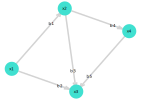

In [28]:
# a simple directed graph on GS p16
g = SimpleDiGraph(4)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 2, 3)
add_edge!(g, 2, 4)
add_edge!(g, 4, 3)
gplot(g, nodelabel=["x1", "x2", "x3", "x4"], edgelabel=["b1", "b2", "b3", "b4", "b5"])

In [29]:
# adjacency matrix A
convert(Matrix{Int64}, adjacency_matrix(g))

4×4 Array{Int64,2}:
 0  1  1  0
 0  0  1  1
 0  0  0  0
 0  0  1  0

In [30]:
# incidence matrix B
convert(Matrix{Int64}, incidence_matrix(g))

4×5 Array{Int64,2}:
 -1  -1   0   0   0
  1   0  -1  -1   0
  0   1   1   0   0
  0   0   0   1  -1

## A view of statistics (or data science)

[XKCD #1838](https://xkcd.com/1838/)

<img src="https://imgs.xkcd.com/comics/machine_learning_2x.png" width=400 align="center"/>